In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import tensorflow_text as text
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from time import time
from Utilities import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
encoder_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"
preprocessor_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"

In [3]:
preprocessor = hub.load(
    preprocessor_path)

In [4]:
encoder = hub.KerasLayer(
        encoder_path, trainable=True)

In [5]:
def build_classifier_model(p):
    
    # Step 1: tokenize batches of text inputs.
    text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]
    
    # Step 2: pack input sequences for the Transformer encoder.
    seq_length = 128  # Your choice here.
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length))  # Optional argument.
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    #encoder_inputs = preprocessor(text_inputs)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 128].
    net = pooled_output
    net = tf.keras.layers.Dropout(p)(net)
    net = tf.keras.layers.Dense(50,activation='softmax')(net)
    
    return tf.keras.Model(text_inputs, net)

In [6]:
Classifier = build_classifier_model(0.1)

Classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, None, None)   0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           keras_layer_1[0][0]              
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 1 4385921     keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]          

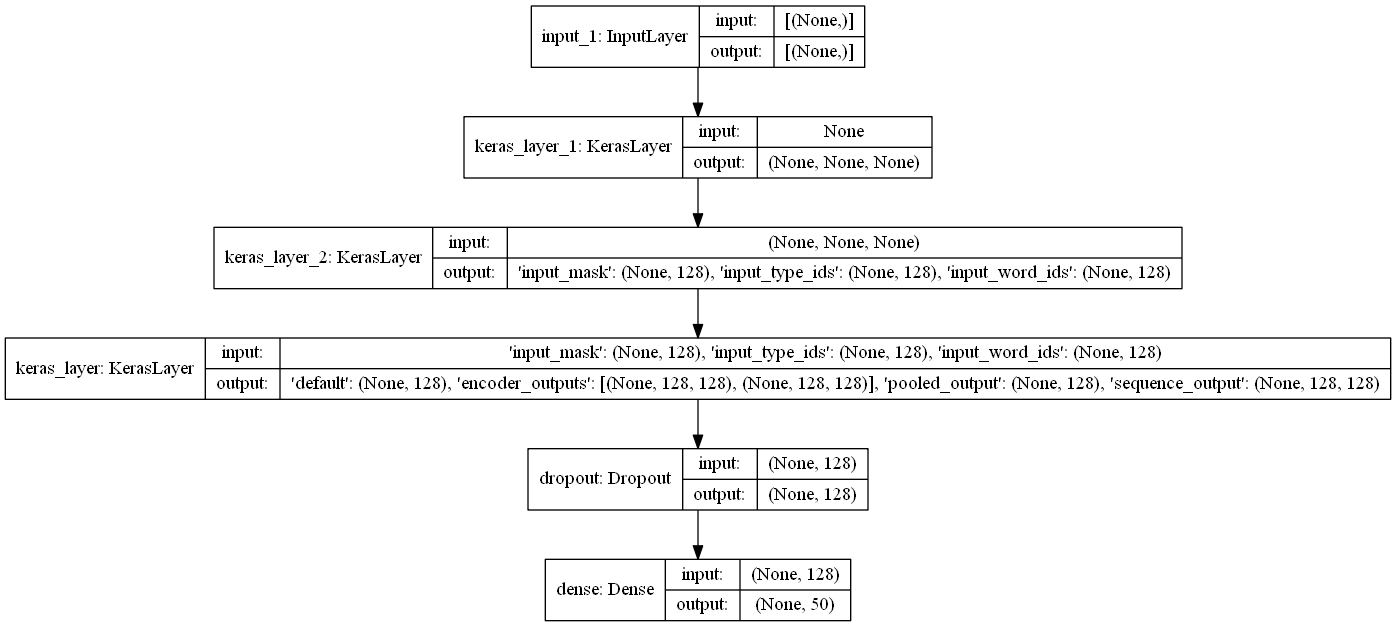

In [7]:
tf.keras.utils.plot_model(Classifier, show_shapes=True)

In [8]:
folder_path_train = 'Data/C50/C50train/'
folder_path_test = 'Data/C50/C50test/'
author_list_train = os.listdir(folder_path_train)
author_list_test = os.listdir(folder_path_test)

Text_train = []
Label_train = []
Author_names = []
k = -1

for author in author_list_train:
    k+=1
    Author_names.append(author)
    works_list_train = os.listdir(folder_path_train+author)
    for work in works_list_train:
        Text_train.append(open(folder_path_train+author+'/'+work).read().lower())
        Label_train.append(k)
        
Text_test = []
Label_test = []
k = -1

for author in author_list_test:
    k+=1
    works_list_test = os.listdir(folder_path_test+author)
    for work in works_list_test:
        Text_test.append(open(folder_path_test+author+'/'+work).read().lower())
        Label_test.append(k)

training_text = np.array(Text_train)
training_labels = np.array(Label_train)
testing_text = np.array(Text_test)
testing_labels = np.array(Label_test)
label_names = np.array(Author_names)

print("Train text length:", len(training_text))
print("Train author length:", len(training_labels))

print("Test text length: ", len(testing_text))
print("Test author length: ", len(testing_labels))

print("Labels: ", len(label_names))

Train text length: 2500
Train author length: 2500
Test text length:  2500
Test author length:  2500
Labels:  50


In [9]:
for k in range(2500):
    if training_labels[k]!=int(np.floor(k/50)):
        print("Error")
        break
    if testing_labels[k]!=int(np.floor(k/50)):
        print("Error")
        break
        
print("All good")

All good


In [10]:
for k in range(50):
    if author_list_train[k]!=label_names[k]:
        print("Error")
        break
    
print("All good")

All good


In [11]:
perm_train = np.random.permutation(2500)
X_train = training_text[perm_train]
y_train = training_labels[perm_train]

perm_test = np.random.permutation(2500)
X_test = testing_text[perm_test]
y_test = testing_labels[perm_test]

In [ ]:
lr_list = 10**np.linspace(-5,-4,3)

time_start = time()
for lr in lr_list:
    #optim = official.nlp.optimization.create_optimizer(init_lr=lr,
    #                                      num_train_steps=3150,
    #                                      num_warmup_steps=315,
    #                                      optimizer_type='adamw')
    model = build_classifier_model(0)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=lr))
    hist = model.fit(X_train,y_train,
                    epochs=50, validation_split=0.2, verbose=1)
    plt.plot(hist.epoch,hist.history['loss'])
plt.title('learning rates')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend(lr_list)
plt.grid()
plt.show()
time_stop = time()
time_elapsed = time_stop - time_start
print('elapsed time',round(time_elapsed/60,2),'minutes')

In [ ]:
p_list = [0,0.9,1]
stopping = tf.keras.callbacks.EarlyStopping(patience=5)
time_start = time()

for p in p_list:
    #optim = official.nlp.optimization.create_optimizer(init_lr=lr,
    #                                      num_train_steps=3150,
    #                                      num_warmup_steps=315,
    #                                      optimizer_type='adamw')
    model = build_classifier_model(p)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001))
    hist = model.fit(X_train,y_train,
                    epochs=50, validation_split=0.2, callbacks=[stopping], verbose=1)
    plt.plot(hist.epoch,hist.history['val_loss'])
plt.title('dropout')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.legend(p_list)
plt.grid()
plt.show()
time_stop = time()
time_elapsed = time_stop - time_start
print('elapsed time',round(time_elapsed/60,2),'minutes')

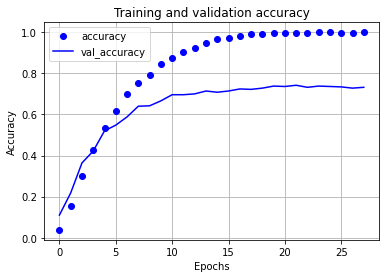

elapsed time 5.5 minutes


In [12]:
stopping = tf.keras.callbacks.EarlyStopping(patience=5)
time_start = time()
model = build_classifier_model(0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_split=0.2, callbacks=[stopping], verbose=0)
plt.plot(hist.epoch,hist.history['accuracy'],'ob')
plt.plot(hist.epoch,hist.history['val_accuracy'],'-b')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc','Validation acc'],'lower right')
plt.show()
time_end = time()
val_loss=pd.Series(hist.history['val_loss']).min()
val_acc = pd.Series(hist.history['val_accuracy']).max()
time_elapsed = time_end - time_start
print('elapsed time',round(time_elapsed/60,2),'minutes')

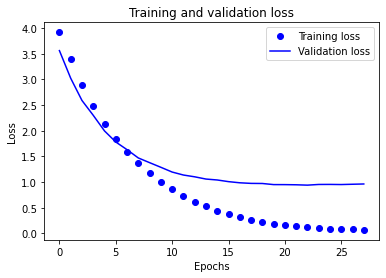

In [17]:
plt.plot(hist.epoch,hist.history['loss'],'ob')
plt.plot(hist.epoch,hist.history['val_loss'],'-b')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss','Validation loss'],loc='upper right')
plt.show()

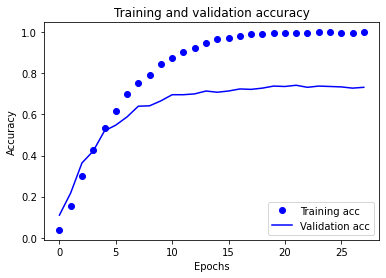

In [14]:
plt.plot(hist.epoch,hist.history['accuracy'],'ob')
plt.plot(hist.epoch,hist.history['val_accuracy'],'-b')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc','Validation acc'],loc='lower right')
plt.show()

In [15]:
yhat_test = model.predict(X_test)
yhat = yhat_test.argmax(axis=1)
print("Test Accuracy:",1-ErrorRate(y_test,yhat))

Test Accuracy: 0.5227999999999999
